# Ejercicio final del módulo 2

El punto de partida es la consideración de que existe un gran problema con la vivienda y el turismo de alquiler de AirBnb en ciudades. Vamos a trabajar con un `dataset` para analizar este problema. 

Se sabe que muchos propietarios privados encuentran más rentable y lucrativo alquilar pisos a turistas que a locales (especialmente en los centros de las ciudades), y muchas agencias inmobiliarias compran propiedades y las convierten también en alojamientos turísticos. Todo esto tiene como efecto reducir la oferta, aumentar los precios y empujar a los comercios locales a otros barrios, dejando solo a los turistas en el centro.

Con esto en mente, y sabiendo que Airbnb es hoy en día uno de los mercados en línea más populares para alojamiento, investigaremos los datos para:

- Por un lado evaluar el impacto que tiene Airbnb en la vivienda (en este caso se analiza la ciudad de Dublin).

- Por otro lado indagar sobre quién, cuándo y cómo se alquila y posiblemente hacer consideraciones sobre los flujos turísticos.

# Importar librerias

Pandas, numpy y seaborn

## Solución

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import streamlit as st
import folium 
from streamlit_folium import st_folium
from wordcloud import WordCloud
from langchain_community.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate 
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import gradio as gr
from PyPDF2 import PdfFileReader

c:\Users\alede\Desktop\PRIMER_PROYECTO\mi_entorno\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargar los anuncios de AirBnb

## Solución

In [2]:
anuncios = pd.read_csv(r'C:\\Users\\alede\\Desktop\\PRIMER_PROYECTO\\SEGUNDO_PROY\\reviews.csv')
anuncios2 = pd.read_csv(r'reviews.csv.gz')
listing = pd.read_csv(r'C:\\Users\\alede\\Desktop\\PRIMER_PROYECTO\\SEGUNDO_PROY\\listings.csv')
listing2 = pd.read_csv(r'listings.csv.gz')
neigh = pd.read_csv(r'neighbourhoods.csv')
neigh2 = gpd.read_file(r'C:\\Users\\alede\\Desktop\\PRIMER_PROYECTO\\SEGUNDO_PROY\\neighbourhoods.geojson')
calendar = pd.read_csv(r'C:\Users\alede\Desktop\PRIMER_PROYECTO\SEGUNDO_PROY\calendar.csv.gz')



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6324\2723043937.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(r'C:\Users\alede\Desktop\PRIMER_PROYECTO\SEGUNDO_PROY\calendar.csv.gz')


In [3]:
listing2.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
# Eliminar el símbolo '$' de la columna 'price'
listing2['price'] = listing2['price'].str.replace('$', '')
listing2['price'] = listing2['price'].str.replace(',', '')
# Convertir la columna 'price' a valores decimales
listing2['price'] = listing2['price'].astype(float)



In [5]:
if listing2.isnull().any().any():
    print("El DataFrame contiene valores nulos.")
else:
    print("El DataFrame no contiene valores nulos.")

El DataFrame contiene valores nulos.


In [6]:
listing2  = listing2.fillna(0)


In [7]:
listing2.to_csv('dublin_df.csv', index=True)

# Vea el contenido del dataset y analice las columnas

No siempre tendremos una descripción de las columnas. Analícelas con los siguientes comandos: `shape`, `dtypes` e `info`.

## Solución

* Reviews

In [8]:
anuncios.shape

(220552, 2)

In [9]:
anuncios.dtypes

listing_id     int64
date          object
dtype: object

In [10]:
anuncios.info

<bound method DataFrame.info of                  listing_id        date
0                     44077  2011-03-20
1                     44077  2011-03-28
2                     44077  2011-04-21
3                     44077  2011-05-13
4                     44077  2011-05-17
...                     ...         ...
220547  1108891275358436606  2024-03-13
220548  1109215277118882748  2024-03-18
220549  1105234094080390986  2024-03-18
220550  1105247167146431437  2024-03-18
220551  1105284243459988057  2024-03-12

[220552 rows x 2 columns]>

In [11]:
anuncios.head()

,listing_id,date
0,44077,2011-03-20
1,44077,2011-03-28
2,44077,2011-04-21
3,44077,2011-05-13
4,44077,2011-05-17


* Reviews 2

In [12]:
anuncios2.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,44077,203703,2011-03-20,393348,Christian,We enjoyed our stay very much. The room was co...
1,44077,211369,2011-03-28,444004,Solidea,We have been here 4 nights. Stay in a home is ...
2,44077,234215,2011-04-21,465058,Michael And Isabelle,Teresa and Hughie were great hosts. They were ...
3,44077,261843,2011-05-13,490005,Weston,"No surprises, was as described. Very gracious..."
4,44077,268148,2011-05-17,520460,Barbara,"Teresa was a lovely hostess, and we had a deli..."


In [13]:
anuncios2.shape

(220552, 6)

* Listing

In [14]:
listing.shape

(4734, 18)

In [15]:
listing.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                           float64
dtype: object

In [16]:
listing.info

<bound method DataFrame.info of                        id                                           name  \
0                   44077            cosy comfortable Irish cottage twin   
1                   85156   Cosy Comfortable Irish Cottage  1 Double Bed   
2                  159889                           Friendly Single Room   
3                  162809             5.5 miles south of Dublin City :^)   
4                  165828                 Pádraig Pearse apt. Kilmainham   
...                   ...                                            ...   
4729  1116663030517500158                               Butterwell House   
4730  1116740544881047841             cozy bedroom in dublin city center   
4731  1116780304065032390               Easy, Convenient, Clean, Relaxed   
4732  1116842332960028519  Room with Private Bathroom, by foot to Centre   
4733  1116873748764937434                                   Dundrum view   

        host_id host_name  neighbourhood_group         

In [17]:
listing.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,44077,cosy comfortable Irish cottage twin,193005,Teresa,NaN,Dn Laoghaire-Rathdown,53.29178,-6.25792,Private room,72,3,326,2024-03-18,2.06,2,129,50,NaN
1,85156,Cosy Comfortable Irish Cottage 1 Double Bed,193005,Teresa,NaN,Dn Laoghaire-Rathdown,53.29209,-6.25624,Private room,71,3,292,2024-03-18,1.87,2,45,56,NaN
2,159889,Friendly Single Room,766611,Marie,NaN,Dublin City,53.39027,-6.23547,Private room,52,2,421,2024-03-20,2.88,3,282,47,NaN
3,162809,5.5 miles south of Dublin City :^),777681,Robbie,NaN,Dn Laoghaire-Rathdown,53.28326,-6.19188,Private room,85,1,377,2024-03-15,3.51,2,81,43,NaN
4,165828,Pádraig Pearse apt. Kilmainham,790601,Timothy,NaN,Dublin City,53.33744,-6.32363,Entire home/apt,188,3,76,2023-12-28,0.50,4,222,3,NaN


In [18]:
listing.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

* Listing 2

In [19]:
listing2.head(1)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,712914322433199115,https://www.airbnb.com/rooms/712914322433199115,20240322023511,2024-03-22,city scrape,Welcome 1-bedroom available. Free parking & Wi-Fi,Single room available in family home. Bus rout...,0,https://a0.muscache.com/pictures/4c044921-f6fd...,89156390,...,4.79,4.93,4.7,0.0,f,2,0,2,0,3.29


In [20]:
listing2.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

* Neighbourhoods

In [21]:
neigh.shape

(4, 2)

In [22]:
neigh.info

<bound method DataFrame.info of    neighbourhood_group          neighbourhood
0                  NaN  Dn Laoghaire-Rathdown
1                  NaN            Dublin City
2                  NaN                 Fingal
3                  NaN           South Dublin>

In [23]:
neigh.dtypes

neighbourhood_group    float64
neighbourhood           object
dtype: object

In [24]:
neigh.head()

,neighbourhood_group,neighbourhood
0,NaN,Dn Laoghaire-Rathdown
1,NaN,Dublin City
2,NaN,Fingal
3,NaN,South Dublin


* Neighbourhoods 2

In [25]:
neigh2.shape

(4, 3)

In [26]:
neigh2.info

<bound method DataFrame.info of            neighbourhood neighbourhood_group  \
0            Dublin City                None   
1           South Dublin                None   
2                 Fingal                None   
3  Dn Laoghaire-Rathdown                None   

                                            geometry  
0  MULTIPOLYGON (((-6.22569 53.41099, -6.22295 53...  
1  MULTIPOLYGON (((-6.41219 53.36780, -6.40812 53...  
2  MULTIPOLYGON (((-6.20563 53.46745, -6.20516 53...  
3  MULTIPOLYGON (((-6.12869 53.29203, -6.12829 53...  >

In [27]:
neigh2.dtypes

neighbourhood            object
neighbourhood_group      object
geometry               geometry
dtype: object

In [28]:
neigh2.head()

,neighbourhood,neighbourhood_group,geometry
0,Dublin City,None,"MULTIPOLYGON (((-6.22569 53.41099, -6.22295 53..."
1,South Dublin,None,"MULTIPOLYGON (((-6.41219 53.36780, -6.40812 53..."
2,Fingal,None,"MULTIPOLYGON (((-6.20563 53.46745, -6.20516 53..."
3,Dn Laoghaire-Rathdown,None,"MULTIPOLYGON (((-6.12869 53.29203, -6.12829 53..."


* Calendar

In [29]:
calendar.head(1)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,44077,2024-03-22,f,$60.00,NaN,3,730


In [30]:
calendar.dtypes

listing_id         int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights     int64
maximum_nights     int64
dtype: object

In [31]:
calendar.shape

(1727910, 7)

# Valores duplicados

Analice  los valores duplicados por las columnas.

Use el comando `duplicated` junto con `sum`.

En esta ocasión quite los valores duplicados con `drop_duplicates`.

## Solución

* Rewiews Duplicated

In [32]:
anuncios.duplicated().sum()

3513

In [33]:
anuncios.drop_duplicates(subset=['listing_id', 'date'], inplace=True)
anuncios.duplicated().sum()


0

* Reviews 2 

In [34]:
anuncios2.duplicated().sum()

0

* Listing Duplicated

In [35]:
listing.duplicated().sum()

0

In [36]:
listing2.duplicated().sum()

0

* Neighbourhoods

In [37]:
neigh.duplicated().sum()

0

In [38]:
neigh2.duplicated().sum()

0

* Calendar

In [39]:
calendar.duplicated().sum()

0

# Compruebe los valores nulos

Para ello use `isnull` junto con `sum`.

## Solución

In [40]:
anuncios.isnull().sum()

listing_id    0
date          0
dtype: int64

In [41]:
anuncios2.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         26
dtype: int64

In [42]:
reviews_copia = anuncios2.copy()
#Se crea un nuevo DF copia para eliminar columnas

In [43]:
listing.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               4734
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                        855
reviews_per_month                  855
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           4734
dtype: int64

In [44]:
listing_copia = listing.copy()
#se crea un nuevo DF copia para eliminar las columnas con nulos

In [45]:
listing2.isnull().sum()

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
source                                          0
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 75, dtype: int64

In [46]:
neigh.isnull().sum()

neighbourhood_group    4
neighbourhood          0
dtype: int64

In [47]:
neigh2.isnull().sum()

neighbourhood          0
neighbourhood_group    4
geometry               0
dtype: int64

In [48]:
neigh2_copia = neigh2.copy()

In [49]:
# Se verifican las variables que vamos a usar para doble check de nulos ya que hay varios con NaN

In [50]:
hay_nulos = reviews_copia['reviewer_id'].isna().any()

print(hay_nulos)

False


In [51]:
list = listing2.copy()

In [52]:
hay_nulos_host_name = list['host_name'].isna().any()

print(hay_nulos_host_name)

False


In [53]:
hay_nulos_host_resp = list['host_response_time'].isna().any()

print(hay_nulos_host_resp)

False


In [54]:
hay_nulos_date = reviews_copia['date'].isna().any()

print(hay_nulos_date)

False


In [55]:
list['neighborhood_overview'].head(30)

0                                                     0
1                                                     0
2                                                     0
3                                                     0
4                                                     0
5                                                     0
6                                                     0
7     Location;<br />We live in a residential locati...
8                                                     0
9                                                     0
10                                Close DCU and Airport
11                                                    0
12                                                    0
13                                                    0
14                                                    0
15                                                    0
16                                                    0
17                                              

In [56]:
hay_nulos_list = list.isna().any().any() #Ver todos los NaN en el DF list

print(hay_nulos_list)


False


In [57]:
columnas_con_nulos = list.columns[list.isna().any()].tolist()

columnas_con_nulos

[]

In [58]:
porcentaje = (list[columnas_con_nulos].isna().sum() / len(list)) * 100
print(porcentaje)

Series([], dtype: float64)


In [59]:
hay_nulos_review = reviews_copia.isna().any().any()

print(hay_nulos_review)

True


In [60]:
hay_nulos_list2 = listing_copia.isna().any().any()

print(hay_nulos_list2)

True


In [61]:
calendar.isnull().sum()

listing_id              0
date                    0
available               0
price                   0
adjusted_price    1727545
minimum_nights          0
maximum_nights          0
dtype: int64

In [62]:
porcentaje_cal = (calendar.isna().sum() / len(list)) * 100
print(porcentaje_cal)

listing_id            0.000000
date                  0.000000
available             0.000000
price                 0.000000
adjusted_price    36492.289818
minimum_nights        0.000000
maximum_nights        0.000000
dtype: float64


# Limpieza de columnas

Elimine las columnas `nombre`, `id`, `host_name` y `last_review`.

No se eliminan nombre, ni id ni host_name porque se utilizaran para el analisis

## Solución

In [63]:
list.drop(['neighborhood_overview'] , axis=1, inplace=True)

In [64]:

listing_copia.drop(['neighbourhood_group', 'license', 'last_review'], axis=1, inplace=True)

In [65]:

neigh2_copia.drop(['neighbourhood_group'], axis=1, inplace=True)


In [66]:
# Comparar si los ID de los datos de la columna ID dos Dataframe son iguales o no. 
id_comparado = pd.merge( listing_copia, listing2, on= 'id' , how='inner')
coincidencias = len(id_comparado) > 0
print(coincidencias)

True


In [67]:
# Comparar si NAME de los datos de la columna ID dos Dataframe son iguales o no. 
name_comparado = pd.merge( listing_copia, list, on= 'name' , how='inner')
coincidencias = len(name_comparado) > 0
print(coincidencias)

True


In [68]:
list['name'].head(10)

0    Welcome 1-bedroom available. Free parking & Wi-Fi
1                                          Kim's House
2                     Private Room Beautiful Townhouse
3                  Home sweet home full room for night
4                         Dublin city centre apartment
5                       Seaside room in cosy apartment
6                             2 bedroom open plan home
7                        Large Comfortable Family Home
8                            Temple Bar Bridge House 3
9     Beautiful 2 Bedroom Apartment just a bus to city
Name: name, dtype: object

In [69]:
listing_copia['name'].head(10)

0                 cosy comfortable Irish cottage twin
1        Cosy Comfortable Irish Cottage  1 Double Bed
2                                Friendly Single Room
3                  5.5 miles south of Dublin City :^)
4                      Pádraig Pearse apt. Kilmainham
5                     The "Michael Collins" apartment
6    Cozy 1 bed apt 10 mins to airport. total privacy
7                       Single cosy bedroom in Lucan.
8     Old World Converted Stables with Swimming Pool.
9         Peaceful retreat for 5 - excellent location
Name: name, dtype: object

In [70]:
#Se eliminan ambos datos. 
list.drop(['name'], axis=1, inplace=True)
listing_copia.drop(['name'], axis=1, inplace=True)

In [71]:
list['host_name']
#No se va a eliminar el host_name porque se utilizará para el analisis

0          Teresa
1             Kim
2       Gabriella
3          Haroon
4            Alev
          ...    
4729        Clara
4730          Joe
4731       Siddik
4732          Joe
4733      Deirdre
Name: host_name, Length: 4734, dtype: object

In [72]:
# Comparar si HOST_NAME de los dos Dataframe son iguales o no. 
hostname_comparado = pd.merge( listing_copia, list, on= 'host_name' , how='inner')
coincidencias = len(hostname_comparado) > 0
print(coincidencias)

True


In [73]:
list['last_review'].head(20)


0     2024-02-16
1     2023-07-07
2     2024-03-16
3              0
4              0
5              0
6              0
7              0
8     2024-02-26
9              0
10    2024-02-25
11    2024-03-11
12             0
13    2024-03-17
14    2023-11-29
15    2021-12-13
16    2024-02-25
17    2024-03-18
18             0
19    2023-12-10
Name: last_review, dtype: object

In [74]:
#Se elimina la columna last review porque faltan datos
list.drop(['last_review'], axis=1, inplace=True)

In [75]:
# Comparar si listing_id es igual a ID  de los dos Dataframe son iguales o no. 
list_id_comparado = pd.merge(reviews_copia, list, left_on='listing_id', right_on='id', how='inner')
coincidencias = len(list_id_comparado) > 0
print(coincidencias)

True


In [76]:
# Se eliminan las columnas del DF List que tengan 100% NaN
list.drop(['neighbourhood_group_cleansed' , 'calendar_updated'], axis=1 , inplace=True)


In [77]:
# Comparar si los ID de los datos de la columna neighbourhood de dos Dataframe son iguales o no. 
neig_comparado = pd.merge(listing_copia, listing2, on='neighbourhood', how='inner')

coincidencias = len(neig_comparado) > 0
print(coincidencias)

False


In [78]:
listing2['neighbourhood'].head(10)

0                                    0
1                                    0
2                                    0
3                                    0
4                                    0
5                                    0
6                                    0
7    Blackrock, County Dublin, Ireland
8                                    0
9                                    0
Name: neighbourhood, dtype: object

In [79]:
#Eliminar la columna 'neighbourhood' de list porque faltan datos. Nos quedamos con los datos en LISTING_COPIA

list.drop(['neighbourhood'], axis=1, inplace=True)

In [80]:
#Eliminar adjusted prices de calendar por la cantidad de nulos
calendar.drop(['adjusted_price'] , axis=1 , inplace=True)

# Análisis de los barrios

Analice la columna `neighbourhood_group` y contee los valores. Use el parámetro `normalize` con valores `True` o `False` para ver su utilidad.

Link de referencia: https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html

## Solución

La columna `neighbourhood_group`  se dropeó por sus valores nulos 4/4

In [81]:
neigh['neighbourhood_group'] #columna del df original

0   NaN
1   NaN
2   NaN
3   NaN
Name: neighbourhood_group, dtype: float64

Se utiliza la coolumna 'neighbourhood' en vez de 'neighbourhood_group'

In [82]:
neigh2_copia['neighbourhood'].value_counts(normalize=True)

neighbourhood
Dublin City              0.25
South Dublin             0.25
Fingal                   0.25
Dn Laoghaire-Rathdown    0.25
Name: proportion, dtype: float64

Todos los barrios de Dublin analizados cuentan con la misma distribución

# Sección

Descripción `shape`, `dtypes` e `info`.

## Solución

In [83]:
list['description'].shape

(4734,)

In [84]:
list['description'].dtypes

dtype('O')

In [85]:
list['description'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4734 entries, 0 to 4733
Series name: description
Non-Null Count  Dtype 
--------------  ----- 
4734 non-null   object
dtypes: object(1)
memory usage: 37.1+ KB


In [86]:
list['description'].head(4)

0    Single room available in family home. Bus rout...
1    Our home is bright and family friendly with a ...
2    Private room in beautiful Victorian-style town...
3    Keep it simple at this peaceful and centrally-...
Name: description, dtype: object

# Tratamiento de la columna `reviews_per_month`

Ponga a 0 aquellos valores nulos de la columna con el comando `fillna`.

## Solución

In [87]:
list.fillna({'reviews_per_month':0}, inplace=True)
list.reviews_per_month.isnull().sum()

0

In [88]:
listing_copia.fillna({'reviews_per_month':0}, inplace=True)
listing_copia.reviews_per_month.isnull().sum()

0

In [89]:
reviews_copia['comments'].fillna('sin información', inplace=True)
#Se aprovecha y se rellena la columna comments 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6324\1906985337.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reviews_copia['comments'].fillna('sin información', inplace=True)


# Quite aquellos valores nulos de las columnas restantes


## Solución

In [90]:
reviews_copia.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [91]:
listing_copia.isnull().sum()

id                                0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

In [92]:
list.isnull().sum()

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
source                                          0
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 69, dtype: int64

In [93]:
neigh2_copia.isnull().sum()

neighbourhood    0
geometry         0
dtype: int64

In [94]:
calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
minimum_nights    0
maximum_nights    0
dtype: int64

# Uee el comando `describe` para ver el estado de los datos



## Solución

In [95]:
reviews_copia.describe()


,listing_id,id,reviewer_id
count,2.205520e+05,2.205520e+05,2.205520e+05
mean,1.553761e+17,4.974531e+17,1.690047e+08
std,3.154149e+17,4.292252e+17,1.533234e+08
min,4.407700e+04,2.037030e+05,3.190000e+02
25%,1.307085e+07,4.357522e+08,4.330612e+07
50%,2.438471e+07,6.302960e+17,1.190190e+08
75%,5.003115e+07,9.106880e+17,2.530470e+08
max,1.111766e+18,1.117389e+18,5.679166e+08


In [96]:
listing_copia.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,4.734000e+03,4.734000e+03,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000
mean,5.890112e+17,1.991458e+08,53.349434,-6.258000,194.513730,5.680608,46.588931,1.519825,6.462188,139.572243,14.865441
std,4.468271e+17,1.923974e+08,0.051978,0.068864,726.124538,20.260000,93.047189,1.963613,13.359616,109.402058,24.380416
min,4.407700e+04,5.764400e+04,53.211910,-6.527050,15.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.916610e+07,3.497959e+07,53.328635,-6.279531,84.000000,1.000000,1.000000,0.200000,1.000000,46.000000,1.000000
50%,7.750133e+17,1.120622e+08,53.344960,-6.259692,130.000000,2.000000,11.000000,0.940000,2.000000,110.000000,5.000000
75%,9.759384e+17,3.918059e+08,53.361910,-6.232599,213.000000,4.000000,48.000000,2.090000,4.000000,224.000000,19.000000
max,1.116874e+18,5.681273e+08,53.623240,-6.055200,45880.000000,729.000000,1537.000000,38.520000,79.000000,365.000000,456.000000


In [97]:
list.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4.734000e+03,4.734000e+03,4.734000e+03,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,...,4734.000000,4734.000000,4734.000000,4734.000000,4734.0,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000
mean,5.890112e+17,2.024032e+13,1.991458e+08,12.609632,22.627376,53.349434,-6.258000,3.250106,1.391952,1.536755,...,3.946213,3.967085,3.883762,3.760237,0.0,6.462188,4.790452,1.306084,0.355725,1.519825
std,4.468271e+17,0.000000e+00,1.923974e+08,78.712880,178.702400,0.051978,0.068864,2.182846,0.809695,1.043842,...,1.886847,1.892269,1.855473,1.817177,0.0,13.359616,13.071325,2.593344,2.415483,1.963613
min,4.407700e+04,2.024032e+13,5.764400e+04,0.000000,0.000000,53.211910,-6.527050,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.916610e+07,2.024032e+13,3.497959e+07,1.000000,1.000000,53.328635,-6.279531,2.000000,1.000000,1.000000,...,4.500000,4.550000,4.400000,4.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.200000
50%,7.750133e+17,2.024032e+13,1.120622e+08,2.000000,3.000000,53.344960,-6.259692,2.000000,1.000000,1.000000,...,4.880000,4.910000,4.750000,4.610000,0.0,2.000000,1.000000,1.000000,0.000000,0.940000
75%,9.759384e+17,2.024032e+13,3.918059e+08,6.000000,8.000000,53.361910,-6.232599,4.000000,1.500000,2.000000,...,5.000000,5.000000,4.920000,4.810000,0.0,4.000000,2.000000,1.000000,0.000000,2.090000
max,1.116874e+18,2.024032e+13,5.681273e+08,2360.000000,5669.000000,53.623240,-6.055200,16.000000,20.000000,20.000000,...,5.000000,5.000000,5.000000,5.000000,0.0,79.000000,79.000000,18.000000,26.000000,38.520000


In [98]:
neigh2_copia.describe()

,neighbourhood,geometry
count,4,4
unique,4,4
top,Dublin City,"MULTIPOLYGON (((-6.225691 53.410993, -6.222949..."
freq,1,1


# Analice la correlación de las variables

Use el comando `corr` y de Seaborn use `heatmap` para respresentarlo.

Importe la librería `matplotlib` para facilitar la representación de los futuros gráficos.

`import matplotlib.pyplot as plt`

 **¿Qué observa con las correlaciones?**

## Solución

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'description', 'picture_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availab

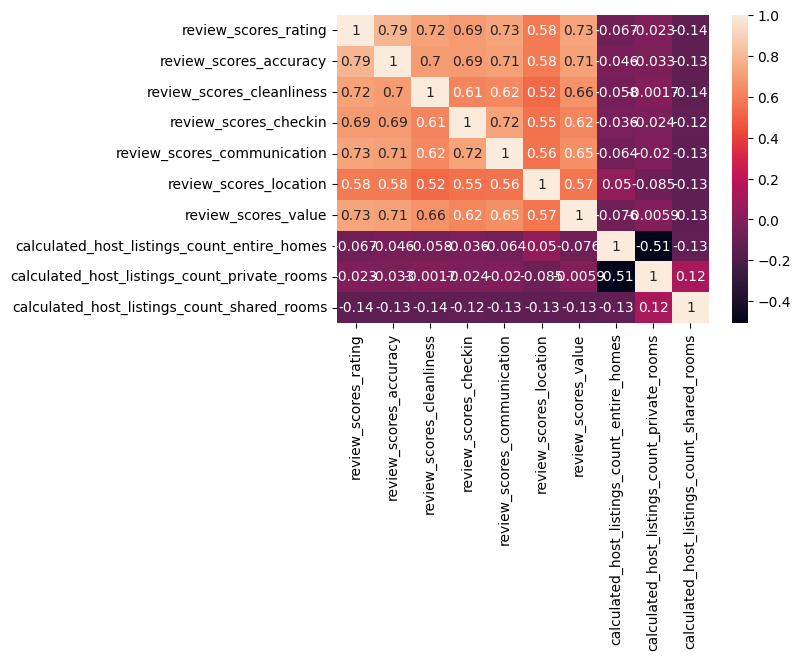

In [99]:
corr = list[['review_scores_rating', 'review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin',
'review_scores_communication', 'review_scores_location','review_scores_value',
'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']].corr(method='kendall' , numeric_only= True)
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True)
list.columns

##### Se correlacionan las variables reviews y tipo de propiedad 

* 'calculated_host_listings_count_entire_homes' el alquiler de casas o pisos enteros tiene más relación con 'review_scores_location' y menos relacion con 'review_scores_value'
* 'calculated_host_listings_count_private_rooms' el alquiler de habitaciones privadas tiene más relación con 'review_scores_cleanliness' (aunque sea negativo entre todos los reviews es el que más cerca del 1 está) y menos relación con 'review_scores_location'
* 'calculated_host_listings_count_shared_rooms' alquiler de habitaciones compartidas tiene más relación con 'review_scores_checkin' y menos que 'review_scores_cleanliness'
- En conclusión: no tienen mucha correlacion las variables analizadas ya que todos estan por debajo del 1. Entre los tres el ultimo se puede decir que tiene un poco más de correlación

## Crear un nuevo DF para hacer otros gráficos

In [100]:
listing_oficial = pd.merge(list, listing_copia, on=['id' ,'host_name', 'room_type', 'reviews_per_month', 'calculated_host_listings_count', 'number_of_reviews_ltm'], suffixes=('_list', '_listing_copia'))


In [101]:
listing_oficial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'description', 'picture_url', 'host_id_list', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude_list', 'longitude_list',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price_list',
       'minimum_nights_list', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'a

In [102]:
listing_oficial.drop(['host_id_listing_copia', 'latitude_listing_copia',
'longitude_listing_copia', 'price_listing_copia','minimum_nights_listing_copia', 'number_of_reviews_listing_copia','availability_365_listing_copia'] , axis =1 , inplace=True)

In [103]:
reviews_copia['date'] = pd.to_datetime(reviews_copia['date']) #date estaba como object ahora esta como data time

# Conteo de palabras que más se repiten en comentarios

In [104]:
reviews_copia.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [105]:
palabras = ' '.join(reviews_copia['comments'])
palabras2 = palabras.split()
conteo_palabras = pd.Series(palabras2).value_counts()
print(conteo_palabras.head(30))

and         383164
the         291994
a           243655
to          241316
was         193726
in          136769
is          135903
very        103062
for         100940
of           91926
The          81358
with         72456
I            67476
we           62743
stay         61209
great        60801
place        58061
you          49759
We           44028
were         43157
our          42229
had          41991
at           40509
it           38143
location     37336
us           35292
as           34961
from         34590
but          32829
so           32078
Name: count, dtype: int64


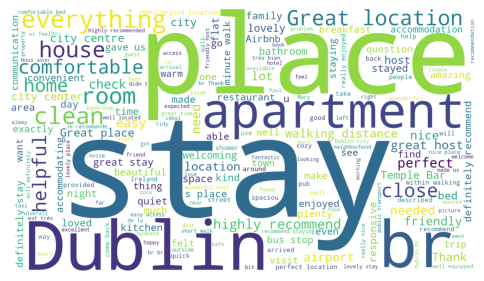

In [106]:
plt.subplots(figsize=(6,4))
conteo_palabras = WordCloud(
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(reviews_copia['comments']))
plt.imshow(conteo_palabras)
plt.axis('off')
plt.show()

# Identifique los barrios del dataset

Use el comando `unique` en la columna `neighbourhood_group`.

## Solución

In [107]:
neigh2_copia['neighbourhood'].unique()


array(['Dublin City', 'South Dublin', 'Fingal', 'Dn Laoghaire-Rathdown'],
      dtype=object)

# Represente los barrios y su importancia

Use `countplot` de `Seaborn` en la columna `neighbourhood_group`.

## Solución

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6324\3912290481.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(listing_copia['neighbourhood'], palette="plasma")


Text(0.5, 1.0, 'Columna: neighbourhood')

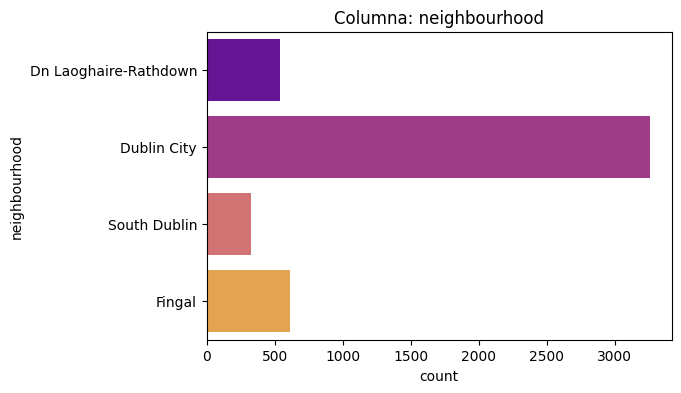

In [108]:
sns.countplot(listing_copia['neighbourhood'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(6,4)
plt.title('Columna: neighbourhood')

# Realice ahora una representación de los barrios por separado y sin agrupar.

Use `countplot` de `Seaborn` en la columna `neighbourhood`.

## Solución

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6324\2164298238.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(listing_copia['neighbourhood'], palette="plasma")


Text(0.5, 1.0, 'Columna: neighbourhood')

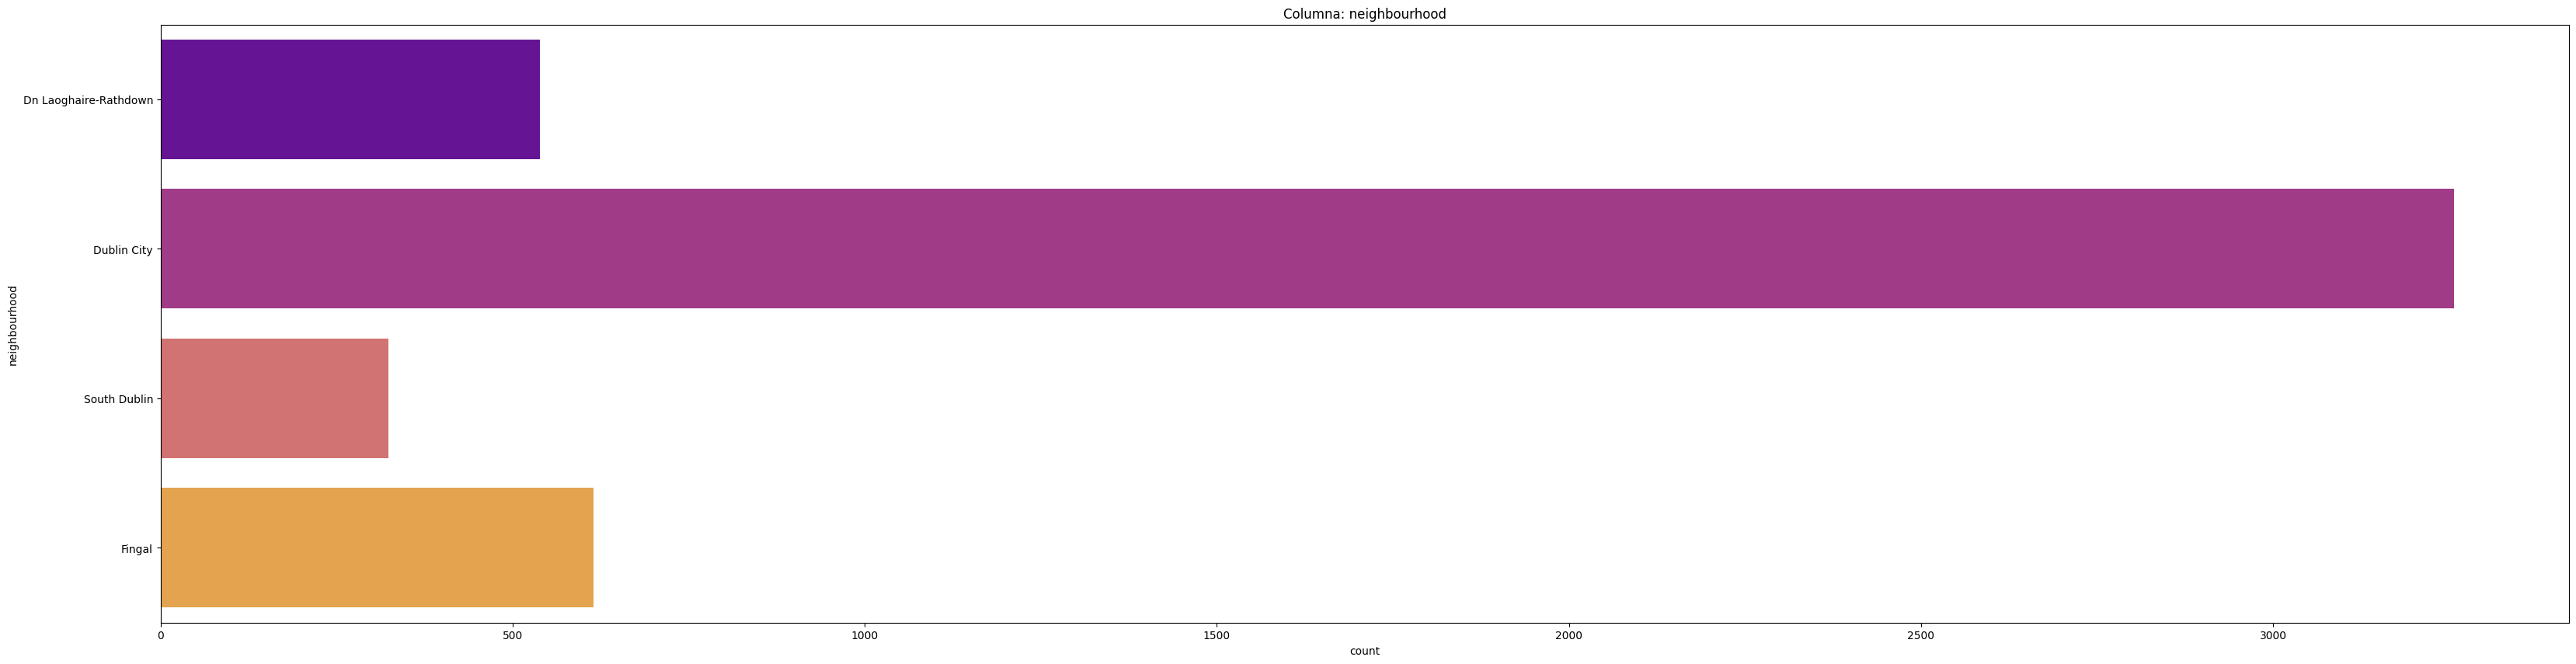

In [109]:
sns.countplot(listing_copia['neighbourhood'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(40,10)
plt.title('Columna: neighbourhood')

# Represente los tipos de habitación que se ofertan

Use la columna `room_type`.

## Solución

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6324\3839766138.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(list['room_type'], palette="plasma")


Text(0.5, 1.0, 'Tipos de habitaciones más ofertadas')

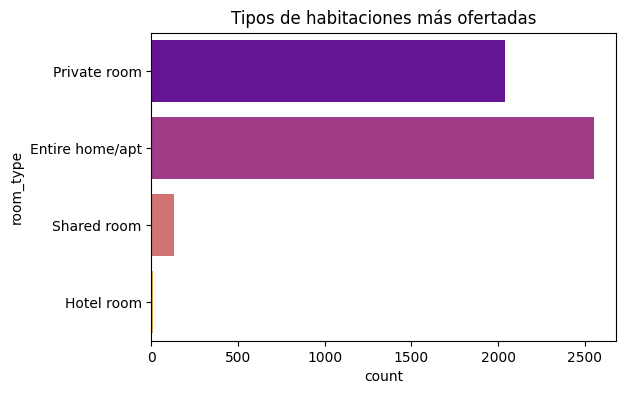

In [110]:
sns.countplot(list['room_type'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(6,4)
plt.title('Tipos de habitaciones más ofertadas')

# Relación entre la columna `neighbour_group` y `availability_365` que corresponde a la disponiblidad

Puede usar un `boxplot` de `sns`.
**¿Qué interpreta?**

## Solución

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6324\3938508591.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=listing_copia, x='neighbourhood',y='availability_365',palette='plasma')


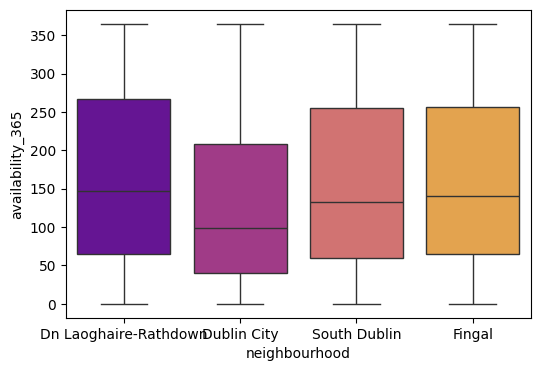

In [111]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(data=listing_copia, x='neighbourhood',y='availability_365',palette='plasma')

Según el gráfico diagrama de caja se visualiza la distribución y la variablidad de los 4 barrios de Dublin con la variable disponible 365 días. 
Con respecto a la dispersión de los datos en las cuatro cajas se observa la linea donde se centran los datos representando el rango intercuartil más alto el barrio Dn Laoghaire-Rathdown es la linea dentro de la caja más alta, quiere decir que la media de sus datos es mayor a la de los demás. 
Aunque la variablididad entre grupos es bastante similar excepto en Dublin City  



# Relicemos un mapa de los grupos de barrios

Use un `scatterplot` de `sns`.

Para ello deberá aportar las columnas `longitude`, `latitude` y como `hue` aporte la columna `neighbourhood_group`.

Link de referencia: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

## Solución

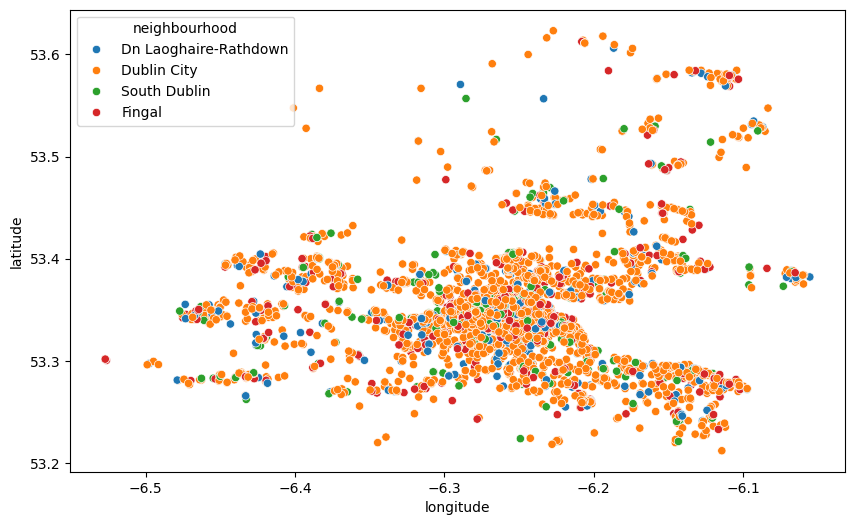

In [112]:
#Para poder hacer este ejercicio se tendrá que combinar dos DF ya que los valores estan en diferentes DF
merged_df = pd.merge(list, listing_copia[['neighbourhood']], left_index=True, right_index=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='longitude', y='latitude', hue='neighbourhood')
plt.ioff() 
plt.show()

# Cree un mapa sobre el tipo de habitación por barrios

Esta vez, use la columna `room_type`.

**¿Qué indica el gráfico?**

## Solución

In [113]:
listing_oficial['longitude_list'].head(20)

0    -6.225530
1    -6.247190
2    -6.248907
3    -6.259367
4    -6.257222
5    -6.134170
6    -6.299530
7    -6.217300
8    -6.262090
9    -6.141310
10   -6.274280
11   -6.320340
12   -6.280230
13   -6.240780
14   -6.251486
15   -6.271130
16   -6.259440
17   -6.258975
18   -6.260260
19   -6.250700
Name: longitude_list, dtype: float64

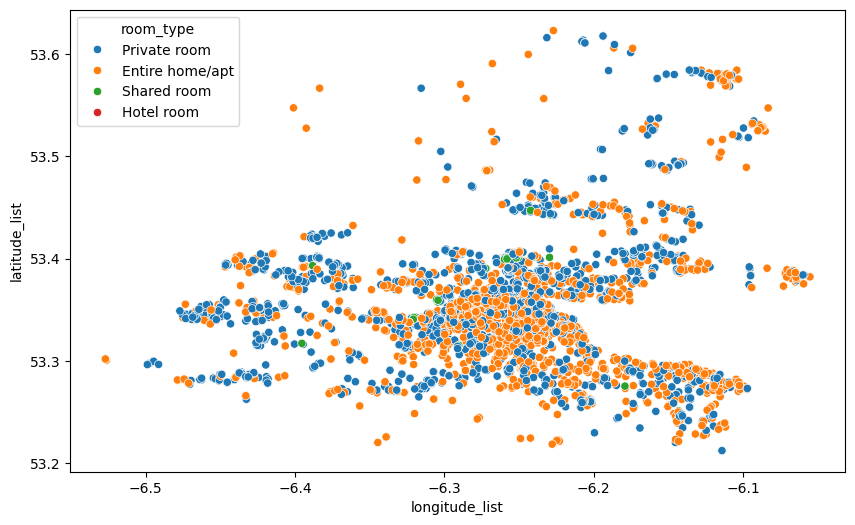

In [114]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data= listing_oficial, x='longitude_list', y='latitude_list', hue='room_type')
plt.ioff() 
plt.show()

# Disponibilidad de las habitaciones

Cree un mapa para ver la disponibilidad de las habitaciones. 

Para ello use la columna `availability_365`.

## Solución

In [115]:
listing_oficial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'description', 'picture_url', 'host_id_list', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude_list', 'longitude_list',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price_list',
       'minimum_nights_list', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'a

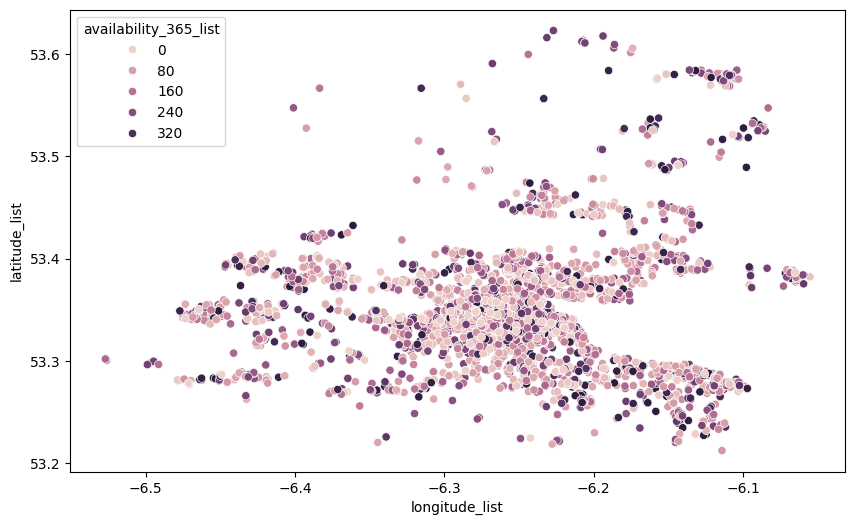

In [116]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data= listing_oficial, x='longitude_list', y='latitude_list', hue='availability_365_list')
plt.ioff() 
plt.show()

# Cuál es el impacto de AIR BNB Dublin con respecto a las viviendas?

In [117]:
# Cantidad total de viviendas disponibles en los cuatro barrios de dublin
total_viviendas_disponibles = listing_oficial['id'].nunique()
total_viviendas_disponibles

4734

In [118]:
# Cantidad total de viviendas disponibles por barrio 
total_viviendas_por_barrio = listing_oficial.groupby('neighbourhood')['id'].nunique()
total_viviendas_por_barrio


neighbourhood
Dn Laoghaire-Rathdown     539
Dublin City              3257
Fingal                    615
South Dublin              323
Name: id, dtype: int64

In [119]:
# Precio minimo por Barrio (identificar las viviendas más caras y más baratas)
precio_viviendas_por_barrio = listing_oficial.groupby('neighbourhood')['price_list'].nunique()
precio_viviendas_por_barrio

neighbourhood
Dn Laoghaire-Rathdown    216
Dublin City              466
Fingal                   216
South Dublin             134
Name: price_list, dtype: int64

In [120]:
#Precios más baratos según el tipo de propiedad
precio_minimo_por_grupo = listing_oficial.groupby(['neighbourhood', 'property_type'])['price_list'].min()
precio_minimo_por_grupo

neighbourhood          property_type             
Dn Laoghaire-Rathdown  Dome                          120.0
                       Earthen home                  479.0
                       Entire bungalow               170.0
                       Entire cabin                  122.0
                       Entire chalet                 450.0
                                                     ...  
South Dublin           Private room in townhouse      48.0
                       Room in aparthotel             69.0
                       Shared room in home            75.0
                       Shared room in rental unit     25.0
                       Tiny home                      88.0
Name: price_list, Length: 133, dtype: float64

In [121]:
#Propiedades disponibles todo el año más baratas
listing_disponible_todo_el_ano = listing_oficial[listing_oficial['availability_365_list'] == 365]

# Precios más baratos según el tipo de propiedad y la disponibilidad
precio_minimo_por_grupo = listing_disponible_todo_el_ano.groupby(['neighbourhood', 'property_type'])['price_list'].min()

# Visualizar los precios mínimos por grupo
print(precio_minimo_por_grupo)


neighbourhood          property_type                    
Dn Laoghaire-Rathdown  Entire home                          277.0
                       Entire rental unit                   127.0
                       Entire serviced apartment            297.0
                       Private room in bed and breakfast     73.0
                       Private room in condo                123.0
                       Private room in home                 200.0
                       Private room in townhouse             95.0
Dublin City            Entire condo                         200.0
                       Entire home                          200.0
                       Entire rental unit                   100.0
                       Entire villa                         204.0
                       Private room in home                  96.0
                       Private room in rental unit           90.0
                       Private room in townhouse            450.0
Fingal             

# Incorporar más información sobre Dublin con IA

In [122]:
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0)
embedding = OpenAIEmbeddings()

In [123]:
pdf1 = "https://www.dublincity.ie/sites/default/files/2023-12/dublin-city-council_tourism-strategy_online_aw_sml.pdf"

#El siguiente paso consiste en crear un array que nos permita entrar al bucle posterior
urls = [pdf1]

In [124]:
# Separar por páginas
pages = []

for url in urls:
    loader = PyPDFLoader(url)
    pages += loader.load_and_split()


In [125]:
len(pages) #total de paginas en todos los pdfs

11

In [126]:
vectorstore = Chroma.from_documents(
    documents = pages, 
    embedding=embedding
    )

In [127]:
retriever = vectorstore.as_retriever()

In [128]:
template = """

        ###INSTRUCCIONES: 
        Eres un asistente de IA dedicado a responder preguntas de manera educada y profesional. Debes proporcionar una respuesta útil al usuario. 
        
        En tu respuesta, POR FAVOR SIEMPRE:
          (0) Sé un lector atento a los detalles: lee la pregunta y el contexto y entiende ambos antes de responder.
          (1) Comienza tu respuesta con un tono amigable y reitera la pregunta para que el usuario esté seguro de que la entendiste.
          (2) Si el contexto te permite responder a la pregunta, escribe una respuesta detallada, útil y fácil de entender, con fuentes referenciadas en el texto. SI NO: no puedes encontrar la respuesta, responde con una explicación, comenzando con: "No pude encontrar la información en las leyes a las que tengo acceso".
          (3) Debajo de la respuesta, por favor enumera todas las fuentes referenciadas (es decir, párrafos legales que respaldan tus afirmaciones).
          (4) Ahora que tienes tu respuesta, eso es increíble - revisa tu respuesta para asegurarte de que responde a la pregunta, es útil y profesional y está formateada para ser fácilmente legible.
        
        
        PIENSA PASO POR PASO 
        ###
        
      Responde a la siguiente pregunta utilizando el contexto proporcionado.
        ### Question: {question} ###
        ### Context: {context} ###     
        ### Respuesta Útil con Fuentes:

        """

    # Creamos nuestra template de prompt
prompt = PromptTemplate.from_template(template)

In [129]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [130]:
ans = chain.invoke("de que se trata el documento?")

print(ans)

¡Hola! El documento es la Estrategia de Turismo del Consejo de la Ciudad de Dublín para el período 2023-2028. En esta estrategia, se amplía el alcance de quiénes se considera que deberían formar parte de la experiencia turística de Dublín, y se crean mecanismos para garantizar que muchas voces, vecindarios y actividades tengan un papel activo en su implementación y éxito. Esta ambición está respaldada por el nuevo Plan de Desarrollo del Consejo de la Ciudad de Dublín 2022-2028. La estrategia se centra en un enfoque centrado en las personas y la comunidad, la sostenibilidad proactiva y medible hacia los objetivos climáticos, y la innovación futurista, creativa y colaborativa.

Además, se han identificado tres objetivos que han dado forma a la estrategia de turismo: centrado en las personas, sostenible e innovador. También se han establecido seis pilares estratégicos para la nueva Estrategia de Turismo (2023-2028): Personas, Lugares y Espacios, Cultura, Acción Climática y Sostenibilidad,

In [131]:
ans = chain.invoke("cual es la estrategia para mejorar los espacios publicos?")

print(ans)

¡Hola! Para mejorar los espacios públicos en Dublín, la estrategia se centra en varios aspectos clave. En primer lugar, se busca mejorar la accesibilidad de la infraestructura turística para reconocer las necesidades de todos los visitantes a la ciudad. Esto incluye el desarrollo y conservación de una variedad de amenidades culturales, sociales, patrimoniales, recreativas y deportivas, así como espacios y comunidades en toda la ciudad. También se busca equilibrar la demanda futura de infraestructura turística con la necesidad de mantener el carácter local y las comunidades dentro de las decisiones de desarrollo y planificación.

Además, se promueve la colaboración con grupos públicos, autoridades, instituciones y empresas privadas para facilitar la mejora continua, la presentación, la seguridad y la limpieza de la infraestructura, calles, parques y lugares donde ocurren las experiencias de los visitantes. También se busca crear una infraestructura turística de clase mundial y experienc

In [132]:
ans = chain.invoke("cual es el plan climatico?")

print(ans)

¡Hola! Según el contexto proporcionado, el plan climático se refiere a las estrategias y acciones que se están tomando para reducir la huella de carbono del turismo en Dublín, en línea con los objetivos climáticos establecidos en el Plan de Desarrollo de la Ciudad de Dublín 2022-2028.

El plan climático incluye la creación de nuevas iniciativas turísticas para atraer a una mezcla de visitantes locales y nacionales con el menor impacto en el medio ambiente y los recursos de la ciudad. También se promueven productos turísticos sostenibles, experiencias sostenibles y modos de transporte sostenibles a través de la cooperación con agencias nacionales de turismo y transporte, así como organismos internacionales de marketing turístico.

Además, el plan climático busca certificar todos los lugares culturales y experiencias turísticas con una acreditación reconocible y estandarizada de turismo sostenible. También se busca incorporar los Objetivos de Desarrollo Sostenible de la ONU y la definici